# Principal Components around FOMC Meetings

This notebook will exmaine Explained Variance of Principal Components for Yield Changes during FOMC meetings. The goal of this notebook is to corroborate a specific claim in the paper *The Pre-FOMC Drift and the Secular Decline in Long-Term Interest Rates* Whitepaper [here](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4764451). The hypothesis from the paper states that explained variances peak around FOMC events. The idea is that yields tend to move in tandom because the FOMC is an anchoring driver.

## Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
from   sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [3]:
sys.path.append(r"C:\Users\Diego\Documents\GitHub\FOMCDrift\root\src")
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FOMCDrift\root\src")
sys.path.append(r"/Users/diegoalvarez/Desktop/research/FOMCDrift/root/src")
from EventDrivenSignalGenerator import EventDrivenSignalGenerator

In [4]:
df_yield        = EventDrivenSignalGenerator().get_tsy_yields()
df_yield_window = EventDrivenSignalGenerator().get_ordered_window(df_yield, before = -6, after = 1)
df_sentiment    = EventDrivenSignalGenerator().get_sentiment()

## Principal Components around FOMC 

In this case run PCA of returns on specific days of the FOMC event. 

In [5]:
def _get_pc_importance(df: pd.DataFrame, num_components: int) -> pd.DataFrame: 
    
    df_wider = (df[
        ["date", "variable", "val_diff"]].
        pivot(index = "date", columns = "variable", values = "val_diff").
        fillna(0))
    
    explained_variance = PCA(n_components = num_components).fit(df_wider).explained_variance_ratio_
    return(pd.DataFrame({
        "comp"   : [i + 1 for i in range(num_components)],
        "exp_var": explained_variance}))

def get_exp_variance(df_yield_window: pd.DataFrame, num_componnets: int = 2) -> pd.DataFrame: 

    df_exp_variance = (df_yield_window.groupby(
        "day").
        apply(_get_pc_importance, num_componnets).
        reset_index().
        drop(columns = ["level_1"]))
    
    return df_exp_variance

df_exp_variance = get_exp_variance(df_yield_window)

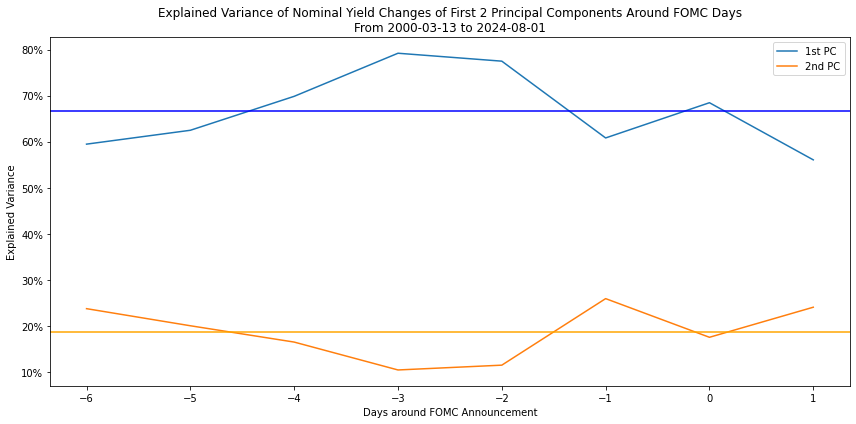

In [6]:
def plot_principal_component(df_exp_variance: pd.DataFrame, df_yield_window: pd.DataFrame) -> pd.DataFrame: 
    
    fig, axes = plt.subplots(figsize = (12,6))

    col_renamer = {
        1: "1st PC",
        2: "2nd PC"}

    col_colorer = {
        1: "Blue",
        2: "Orange"}

    avg_dict = (df_exp_variance.drop(
        columns = ["day"]).
        groupby("comp").
        agg("mean").
        exp_var.
        to_dict())

    (df_exp_variance.rename(
        columns = {"comp": ""}).
        pivot(index = "day", columns = "", values = "exp_var").
        rename(columns = col_renamer).
        plot(
            ax     = axes,
            xlabel = "Days around FOMC Announcement",
            ylabel = "Explained Variance",
            title  = "Explained Variance of Nominal Yield Changes of First 2 Principal Components Around FOMC Days\nFrom {} to {}".format(
                df_yield_window.date.min(),
                df_yield_window.date.max())))

    axes.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))
    for comp in col_renamer.keys(): axes.axhline(avg_dict[comp], c = col_colorer[comp])
    plt.tight_layout()
    
plot_principal_component(df_exp_variance, df_yield_window)

## Conditioning Principal Components on sentiment of FOMC announcements

In this case using the z-score of the sentiment indicator to condition against the PCs. 

In [7]:
def _get_zscore(df: pd.DataFrame, window: int) -> pd.DataFrame: 

    df_out = (df.sort_values(
        "date").
        assign(
            date      = lambda x: pd.to_datetime(x.date).dt.date,
            roll_mean = lambda x: x.value.ewm(span = window, adjust = False).mean(),
            roll_std  = lambda x: x.value.ewm(span = window, adjust = False).std(),
            zscore    = lambda x: ((x.value - x.roll_mean) / x.roll_std).shift()).
        dropna())
    
    return df_out
    
def get_zscore(df_sentiment: pd.DataFrame, window: int = 10) -> pd.DataFrame:
    
    df_zscore = (df_sentiment.query(
        "security != ['BENLPFPD', 'APUSXRGF']").
        groupby("security").
        apply(_get_zscore, window).
        reset_index(drop = True))
    
    return df_zscore

df_zscore = get_zscore(df_sentiment)

In [8]:
def get_condition_exp_var(df_yield_window: pd.DataFrame, df_zscore: pd.DataFrame, num_components: int = 2) -> pd.DataFrame: 

    df_condition = (df_yield_window.query(
        "day == -3")
        [["date", "event"]].
        drop_duplicates().
        assign(date = lambda x: pd.to_datetime(x.date).dt.date).
        sort_values("date").
        merge(right = df_zscore, how = "inner", on = ["date"]).
        assign(condition = lambda x: np.where(x.zscore > 0, "Pos ZScore", "Neg ZScore"))
        [["security", "Description", "condition", "event"]])      
                
    df_prep = (df_yield_window.merge(
        right = df_condition, how = "inner", on = ["event"]).
        assign(group_var = lambda x: x.condition + " " + x.security + " "  + x.day.astype(str)))

    df_namer = (df_prep[
        ["group_var", "day", "security", "Description", "condition"]].
        drop_duplicates())

    df_out = (df_prep[
        ["date", "group_var", "val_diff", "variable"]].
        groupby("group_var").
        apply(_get_pc_importance, num_components).
        reset_index().
        drop(columns = ["level_1"]).
        merge(right = df_namer, how = "inner", on = ["group_var"]).
        drop(columns = ["group_var"]))
    
    return df_out

df_conditioned_pc = get_condition_exp_var(df_yield_window, df_zscore)

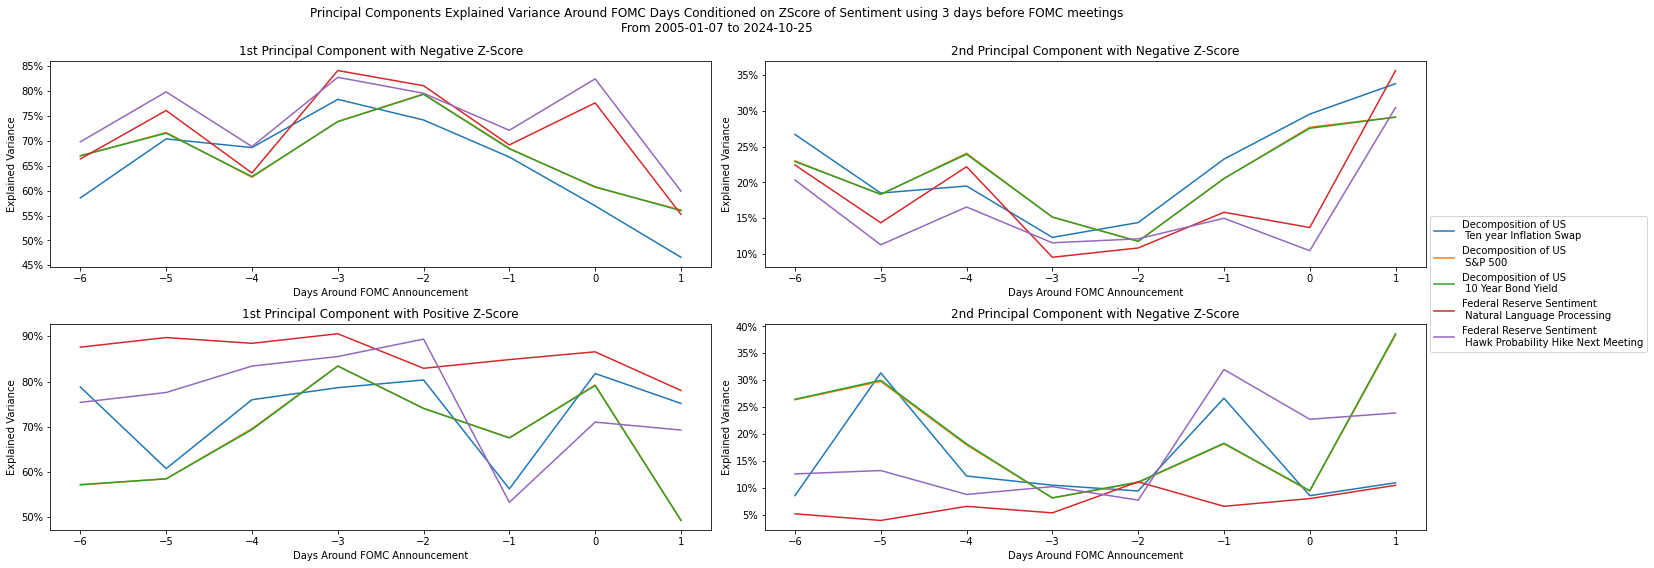

In [9]:
def plot_conditioned_pc(df_conditioned_pc: pd.DataFrame, df_zscore: pd.DataFrame) -> plt.Figure: 
    
    col_renamer = (df_conditioned_pc[
        ["security", "Description"]].
        drop_duplicates().
        assign(Description = lambda x: x.Description.str.split("-").str[0].str.strip()).
        assign(Description = lambda x: x.Description.str.split("cs").str[1].str.strip()).
        assign(Description = lambda x: x.Description.str.replace("US", "US\n").str.replace("Sentiment", "Sentiment\n")).
        set_index("security")
        ["Description"].
        to_dict())

    renamer = {
        "1 Neg ZScore": "1st Principal Component with Negative Z-Score",
        "2 Neg ZScore": "2nd Principal Component with Negative Z-Score",
        "1 Pos ZScore": "1st Principal Component with Positive Z-Score",
        "2 Pos ZScore": "2nd Principal Component with Negative Z-Score"}

    df_tmp = (df_conditioned_pc.assign(
        group_var = lambda x: x.comp.astype(str) + " " + x.condition))

    group_vars = df_tmp.group_var.drop_duplicates()

    fig, axes = plt.subplots(
        ncols   = len(group_vars) // 2,
        nrows   = len(group_vars) // 2,
        figsize = (20,8))

    for group_var, ax in zip(group_vars, axes.flatten()): 

        (df_tmp.query(
            "group_var == @group_var")
            [["day", "exp_var", "security"]].
            pivot(index = "day", columns = "security", values = "exp_var").
            rename(columns = col_renamer).
            plot(
                ax     = ax,
                legend = False,
                ylabel = "Explained Variance",
                xlabel = "Days Around FOMC Announcement",
                title  = renamer[group_var]))
        
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))

    fig.legend(
        *ax.get_legend_handles_labels(),  
        loc            = "center right",               
        bbox_to_anchor = (1.15, 0.5),        
        title          = "")

    fig.suptitle("Principal Components Explained Variance Around FOMC Days Conditioned on ZScore of Sentiment using 3 days before FOMC meetings\nFrom {} to {}".format(
        df_zscore.date.min(),
        df_zscore.date.max()))

    plt.tight_layout()
    
plot_conditioned_pc(df_conditioned_pc, df_zscore)